# Reimplementing the comparison of two losses: cross entropy and mean squared error

Attempt to reimplement the losses and obtain the same figure as Glorot and Bengio.

Source: Glorot and Bengio, _Understanding the difficulty of training deep feedforward neural networks_, Sect. 4.1, Fig. 5, Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (AISTATS) 2010, Chia Laguna Resort, Sardinia, Italy. Volume 9 of JMLR: W&CP 9


https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf


In [1]:
import torch
import torch.nn as nn

In [2]:
model = nn.Sequential(
    nn.Linear(1, 1, bias=False),
    nn.Tanh(),
    nn.Linear(1, 1, bias=False),
    nn.Tanh(),
    nn.Sigmoid()
)

In [3]:
model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=False)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=1, bias=False)
  (3): Tanh()
  (4): Sigmoid()
)

In [4]:
model.state_dict()

OrderedDict([('0.weight', tensor([[0.2037]])),
             ('2.weight', tensor([[-0.4494]]))])

In [5]:
list(model.parameters())

[Parameter containing:
 tensor([[0.2037]], requires_grad=True),
 Parameter containing:
 tensor([[-0.4494]], requires_grad=True)]

In [6]:
def set_weights(model, w1, w2):
    (w1, w2) = torch.FloatTensor([w1, w2])
    model[0].weight = nn.Parameter(torch.Tensor([[w1]]))
    model[2].weight = nn.Parameter(torch.Tensor([[w2]]))
    return model

In [7]:
set_weights(model, 4.0, 4.0)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=False)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=1, bias=False)
  (3): Tanh()
  (4): Sigmoid()
)

In [8]:
model.state_dict()

OrderedDict([('0.weight', tensor([[4.]])), ('2.weight', tensor([[4.]]))])

## I tried a variety of possible losses from the description in the paper

In [9]:
"""def losses(model, trials=1000):
    p = torch.unsqueeze(torch.rand(trials), dim=1)
    m = model(p)
    #m = model(2.0 * (p - 0.5))
    #m = model(torch.unsqueeze(2 * ((torch.rand(trials) - 0.5)), dim=1))
    ce = -torch.mean(p * torch.log(m))
    mse = torch.mean((p - m)**2)
    return ce, mse"""

'def losses(model, trials=1000):\n    p = torch.unsqueeze(torch.rand(trials), dim=1)\n    m = model(p)\n    #m = model(2.0 * (p - 0.5))\n    #m = model(torch.unsqueeze(2 * ((torch.rand(trials) - 0.5)), dim=1))\n    ce = -torch.mean(p * torch.log(m))\n    mse = torch.mean((p - m)**2)\n    return ce, mse'

In [10]:
def losses_1(model, trials=10000):
    """
    The random input is the truth
    """
    p = torch.unsqueeze(torch.rand(trials), dim=1)  # random input signal prob. relative to class 1
    # m = model(torch.unsqueeze(torch.rand(trials), dim=1))
    m = model(p)
    p_0 = (p < 0.5).float()  # class 0
    p_1 = (p >= 0.5).float()  # class 1
    p = p_0 * (1 - p) + p_1 * p  # prob. relative to class 0 and 1
    m = p_0 * (1 - m) + p_1 * m
    ce = -torch.mean(p * torch.log(m))
    mse = torch.mean((p - m)**2)
    return ce, mse

In [11]:
def losses_2(model, trials=10000):
    """
    The random output is the truth
    """
    p = torch.unsqueeze(torch.rand(trials), dim=1)  # random input signal prob. relative to class 1
    # m = model(torch.unsqueeze(torch.rand(trials), dim=1))
    m = model(p)
    out = torch.unsqueeze(torch.rand(trials), dim=1)  # random output signal
    out_0 = (out < 0.5).float()  # class 0
    out_1 = (out >= 0.5).float()  # class 1
    out = out_0 * (1 - out) + out_1 * out  # prob. relative to class 0 and 1
    m = out_0 * (1 - m) + out_1 * m
    ce = -torch.mean(out * torch.log(m))
    mse = torch.mean((out - m)**2)
    return ce, mse

In [12]:
def losses_3(model, trials=10000):
    """
    Binary signals
    """
    # random input signal. prob. relative to class 1
    p = torch.randint(0, 2, (trials, 1)).float()
    m = model(p)
    out = torch.randint(0, 2, (trials, 1)).float()  # random output signal
    out_0 = (out < 0.5).float()  # class 0
    out_1 = (out >= 0.5).float()  # class 1
    out = out_0 * (1 - out) + out_1 * out  # prob. relative to class 0 and 1
    m = out_0 * (1 - m) + out_1 * m
    ce = -torch.mean(out * torch.log(m))
    mse = torch.mean((out - m)**2)
    return ce, mse

In [13]:
def losses_4(model, trials=10000):
    """
    The random output is the truth
    """
    p = torch.unsqueeze(torch.rand(trials), dim=1)  # random input signal prob. relative to class 1
    # m = model(torch.unsqueeze(torch.rand(trials), dim=1))
    m = model(p)
    out = torch.unsqueeze(torch.rand(trials), dim=1)  # random output signal
    ce = -torch.mean(out * torch.log(m))
    mse = torch.mean((out - m)**2)
    return ce, mse

`losses_1` is the one that works best, but it does not match perfectly Fig. 5 of the paper.

In [14]:
losses = losses_1

In [15]:
losses(model)

(tensor(0.5814, grad_fn=<NegBackward0>),
 tensor(0.1248, grad_fn=<MeanBackward0>))

In [16]:
model = set_weights(model, -4.0, -4.0)

In [17]:
losses(model)

(tensor(0.5787, grad_fn=<NegBackward0>),
 tensor(0.1240, grad_fn=<MeanBackward0>))

In [18]:
ce_l = []
mse_l = []
x_l = torch.linspace(-4, 4, 100)
y_l = torch.linspace(-4, 4, 100)
for w1, w2 in [(w1, w2) for w1 in x_l for w2 in y_l]:
    model = set_weights(model, w1, w2)
    ce, mse = losses(model)
    ce_l += [ce]
    mse_l += [mse]

x_l = x_l.numpy()
y_l = y_l.numpy()
ce_l = torch.tensor(ce_l).numpy()
mse_l = torch.tensor(mse_l).numpy()

In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
def plot(fig, ax, X, Y, Z, color):
    # ax.view_init(azim=210)
    X, Y = np.meshgrid(X, Y)
    Z = Z.reshape(X.shape)
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=color,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

In [21]:
def plot_descent(X, Y, Z1, Z2):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    plot(fig, ax, X, Y, Z1, plt.cm.coolwarm)
    plot(fig, ax, X, Y, Z2, plt.cm.rainbow)

    plt.show()

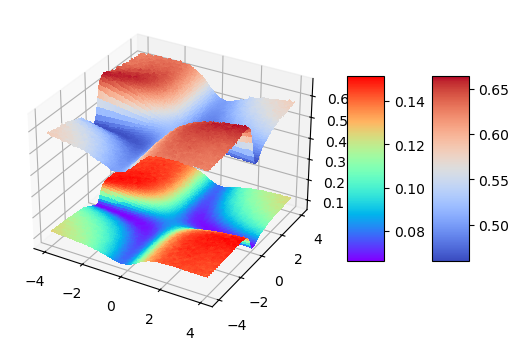

In [22]:
plot_descent(x_l, y_l, ce_l, mse_l)